### Installing Libraries

In [ ]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 46.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!pip install foolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00


In [ ]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm.notebook import tqdm as tqdm
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.datasets as datasets
import copy
from tqdm.notebook import tqdm as tqdm
import time
import timeit
import torch.nn.utils.prune as prune
import torch.quantization as quant
import matplotlib.pyplot as plt
import foolbox as fb

In [ ]:
from boundary_attack_biased import BoundaryAttack

### Data preprocessing

In [ ]:
# Define transform
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:13<00:00, 13080249.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
test_dataset[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
trainloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Training the Model

In [ ]:
# Define the loss function and optimizer
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()
resnet50 = torch.load('/content/substitute_boundary_attack/models/CIFAR10_ResNet50.pth', map_location=device)
optimizer_resnet50 = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [ ]:
def evaluate(model, testloader, device):
    with torch.no_grad():
        val_loss, val_acc = 0.0, 0.0
        for val_batch in testloader:
            imgs, targets = val_batch
            imgs, targets = imgs.to(device), targets.to(device).long()
            val_outputs = model(imgs)
            val_loss += torch.nn.functional.cross_entropy(val_outputs, targets).item()
            val_preds = torch.argmax(val_outputs, dim=1)
            val_acc += torch.sum(val_preds == targets)
    val_acc = float(float(val_acc)/float(len(testloader)*256))
    return val_acc

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_epochs = 5

def train(model, optimizer, trainloader, testloader):
    model.to(device)
    model.train()

    acc_of_epochs = []
    loss_of_epochs = []
    for epoch in range(num_epochs):
        train_loss, train_acc = 0, 0
        print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

        with tqdm(total=len(trainloader)) as pbar:
            for idx, batch in enumerate(trainloader):
            
                images, labels = batch
                images, labels = images.to(device), labels.to(device).long()
                
                preds = model(images)
                loss = torch.nn.functional.cross_entropy(preds, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                acc = torch.sum(torch.argmax(preds, dim=1) == labels)
                train_acc += acc
                pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                                Accuracy='{0:.4f}'.format(float(train_acc.item()/(256.0*(idx+1)))))
                pbar.update(1)

            #print("epoch completed")
            val_acc = evaluate(model, testloader, device)
            print("train_acc:", round(float(float(train_acc)/float(len(trainloader)*256)), 4), " val_acc:", round(val_acc, 4), "train_loss:", round(float(float(train_loss)/float(len(trainloader)*256)), 4))
        acc_of_epochs.append(val_acc)
        loss_of_epochs.append(float(float(train_loss)/float(len(trainloader)*256)))
    return acc_of_epochs, loss_of_epochs


In [ ]:
resnet_acc, resnet_loss = train(resnet50, optimizer_resnet50, trainloader, testloader)

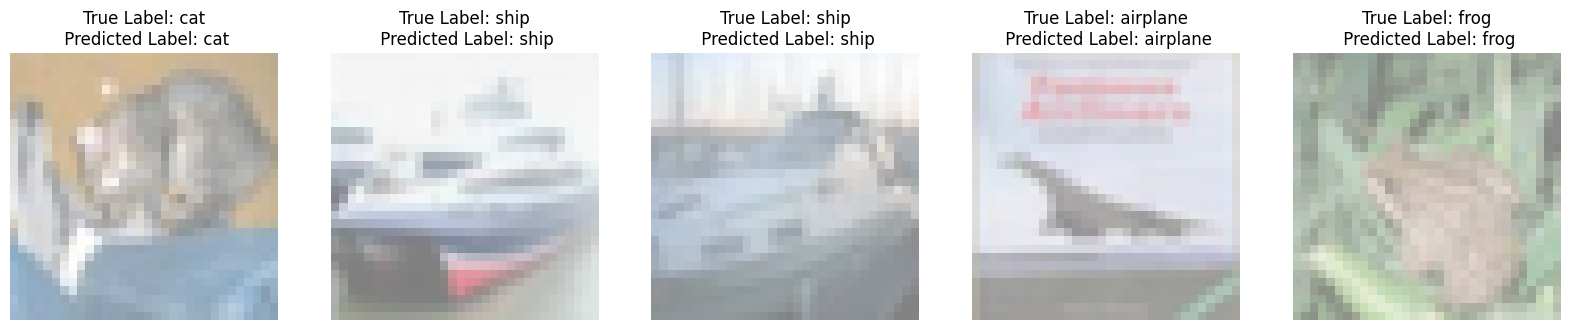

In [ ]:
# Showing the true label, predicted label, and corresponding images for 5 images in a row
with torch.no_grad():
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    for i, (inputs, labels) in enumerate(testloader):
        if i == 1: # break after first batch of 64 images
            break
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs, 1)
        for j in range(5):
            image = inputs[j].cpu().numpy().transpose(1,2,0)
            image = (image * 0.5) + 0.5 # unnormalize
            axs[j].imshow(image)
            axs[j].set_title(f"True Label: {test_dataset.classes[labels[j]]}\n Predicted Label: {test_dataset.classes[predicted[j]]}")
            axs[j].axis('off')
    plt.show()

### Attacking the Model with Boundary Biased Attack

In [ ]:
examples = enumerate(test_dataset)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
init = 1
start = 4

input_or_adv = test_dataset[init][0]
example_targets = test_dataset[init][1]
starting_points = test_dataset[start][0]

In [ ]:
input_or_adv = input_or_adv.reshape(1, 3, 32, 32)
starting_points = starting_points.reshape(1, 3, 32, 32)

In [ ]:
input_or_adv = input_or_adv.to(device)
starting_points = starting_points.to(device)
label = torch.tensor([example_targets]).to(device)

In [ ]:
fmodel = fb.PyTorchModel(resnet50, bounds=(0, 1), device=device)
attack = BoundaryAttack(steps=10000, tensorboard='./logs')

In [ ]:
%%time

adversarial = attack(model=fmodel, 
                     inputs=input_or_adv, 
                     starting_points=starting_points, 
                     criterion=fb.criteria.Misclassification(label), 
                     epsilons=1e-3)

  5%|▍         | 497/10000 [00:17<03:28, 45.67it/s]/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

  0%|          | 0.00/44.7M [00:00<?, ?B/s]
  4%|▍         | 1.75M/44.7M [00:00<00:02, 17.7MB/s]
  8%|▊         | 3.50M/44.7M [00:00<00:02, 16.7MB/s]
 12%|█▏        | 5.25M/44.7M [00:00<00:02,

CPU times: user 7min 44s, sys: 13.7 s, total: 7min 57s
Wall time: 7min 59s


In [ ]:
adv = adversarial[0].cpu().numpy()
input_or_adv = input_or_adv.to('cpu')
starting_points = starting_points.to('cpu')

<ipython-input-20-9749bc05b453>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


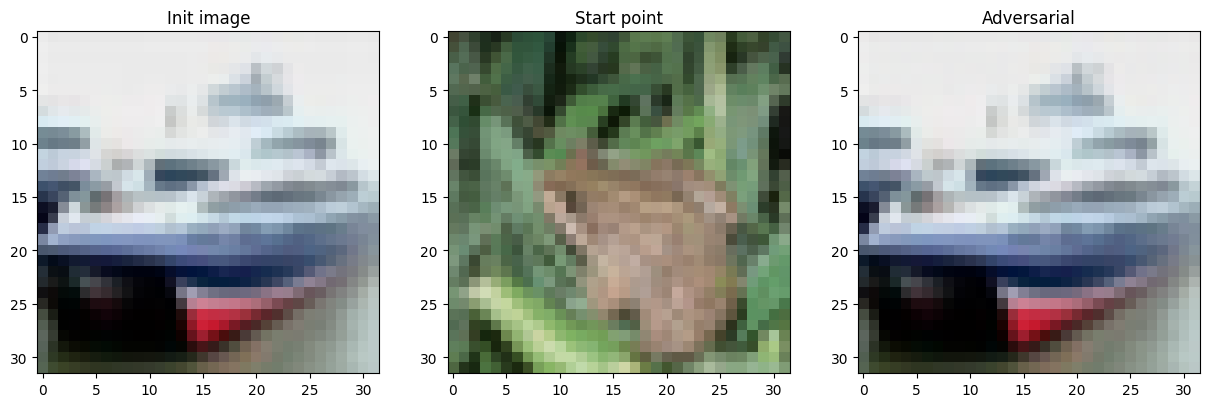

In [ ]:
import numpy as np
fig, ax = plt.subplots(figsize=[15, 25])

plt.subplot(131)
plt.imshow(np.array(input_or_adv[0]).transpose((1,2,0)))
plt.title('Init image')
plt.savefig('init_image.png')

plt.subplot(132)
plt.imshow(np.array(starting_points[0]).transpose((1,2,0)))
plt.title('Start point')

plt.subplot(133)
plt.imshow(np.array(adv[0]).transpose((1,2,0)))
plt.title('Adversarial')
plt.savefig('adversarial_image.png')

plt.show()

In [ ]:
from scipy.special import softmax

In [ ]:
before = resnet50.forward(input_or_adv.to(device)).cpu().detach().numpy()
label_before = np.argmax(before)
before_prob = softmax(before)[0][label_before]
print('label before:', label_before, '  prob before:', before_prob)

after = resnet50.forward(adversarial[0]).cpu().detach().numpy()
label_after = np.argmax(after)
prob_after = softmax(after)[0][label_after]
prob_after_init = softmax(after)[0][label_before]
print('label after:', label_after, '   prob after:', prob_after, '   prob init:', prob_after_init)

label before: 8   prob before: 0.61737555
label after: 1    prob after: 0.4981095    prob init: 0.49803916


### Comparision of Attacks

#### Boundary Biased Attack

In [ ]:
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples

# apply the attack

epsilons = [
    0.001,
    0.01,
    0.1,
    1
]

# images, labels = ep.astensors(*samples(fmodel, dataset="cifar10"))
raw_advs, clipped_advs, success_advs = attack(fmodel, input_or_adv,label, epsilons=epsilons)

In [ ]:
# calculate and report the robust accuracy (the accuracy of the model when it is attacked)
robust_accuracy = 1 - raw_advs[0].mean(dim=tuple(range(1, len(raw_advs[0].shape)))).float()
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  epsilon ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

robust accuracy for perturbations with
  epsilon ≤ 0.001 : 39.2 %


In [ ]:
# calculate and report the robust accuracy (the accuracy of the model when it is attacked)
robust_accuracy = 1 - raw_advs1[0].mean(dim=tuple(range(1, len(raw_advs1[0].shape)))).float()
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  epsilon ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

robust accuracy for perturbations with
  epsilon ≤ 0.001 : 41.0 %
  epsilon ≤ 0.01  : 39.6 %
  epsilon ≤ 0.1   : 37.1 %


#### FGSM

In [ ]:
# apply the attack
attack = fb.attacks.fast_gradient_method.LinfFastGradientAttack()
epsilons = [
    0.001,
    0.01,
    0.1,
    1
]

images, labels = ep.astensors(*samples(fmodel, dataset="cifar10", batchsize=128))
raw_advs_fgsm, clipped_advs_fgsm, success_fgsm = attack(fmodel, images,labels, epsilons=epsilons)

# calculate and report the robust accuracy (the accuracy of the model when
# it is attacked)
robust_accuracy = 1 - success_fgsm.float32().mean(axis=-1)
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  epsilon ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

robust accuracy for perturbations with
  epsilon ≤ 0.001 : 84.4 %
  epsilon ≤ 0.01  : 18.8 %
  epsilon ≤ 0.1   :  5.5 %
  epsilon ≤ 1     :  4.7 %


#### Boundary Attack

In [ ]:
attack = fb.attacks.BoundaryAttack()
epsilons = [
    0.001,
    0.01,
    0.1,
    1
]

images, labels = ep.astensors(*samples(fmodel, dataset="cifar10", batchsize=128))
raw_advs_fgsm, clipped_advs_fgsm, success_fgsm = attack(fmodel, images,labels, epsilons=epsilons)

# calculate and report the robust accuracy (the accuracy of the model when
# it is attacked)
robust_accuracy = 1 - success_fgsm.float32().mean(axis=-1)
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  epsilon ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

robust accuracy for perturbations with
  epsilon ≤ 0.001 : 95.3 %
  epsilon ≤ 0.01  : 95.3 %
  epsilon ≤ 0.1   : 95.3 %
  epsilon ≤ 1     : 88.3 %


#### PGD

In [ ]:
# apply the attack
attack = fb.attacks.LinfPGD()
epsilons = [
    0.001,
    0.01,
    0.1,
    1
]

images, labels = ep.astensors(*samples(fmodel, dataset="cifar10", batchsize=128))
raw_advs_pgd, clipped_advs_pgd, success_pgd = attack(fmodel, images,labels, epsilons=epsilons)

# calculate and report the robust accuracy (the accuracy of the model when
# it is attacked)
robust_accuracy = 1 - success_pgd.float32().mean(axis=-1)
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

/home/user/.local/lib/python3.8/site-packages/foolbox/utils.py:80: UserWarning: samples() has only 20 samples and repeats itself if batchsize > 20
  warnings.warn(


robust accuracy for perturbations with
  Linf norm ≤ 0.001 : 84.4 %
  Linf norm ≤ 0.01  :  9.4 %
  Linf norm ≤ 0.1   :  0.0 %
  Linf norm ≤ 1     :  0.0 %


#### HopSkipJump

In [ ]:
# apply the attack
attack = fb.attacks.HopSkipJumpAttack()
epsilons = [
    0.001,
    0.01,
    0.1,
    1
]

images, labels = ep.astensors(*samples(fmodel, dataset="cifar10", batchsize=128))
raw_advs_fgsm, clipped_advs_fgsm, success_fgsm = attack(fmodel, images,labels, epsilons=epsilons)

# calculate and report the robust accuracy (the accuracy of the model when
# it is attacked)
robust_accuracy = 1 - success_fgsm.float32().mean(axis=-1)
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

robust accuracy for perturbations with
  Linf norm ≤ 0.001 : 79.7 %
  Linf norm ≤ 0.01  : 79.7 %
  Linf norm ≤ 0.1   : 79.7 %
  Linf norm ≤ 1     : 28.9 %


### Adversarial training 

In [ ]:
import art
from art.defences.trainer import AdversarialTrainer
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier

# Move the model to the GPU (if available)
model = resnet50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 1
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Define the ART classifier
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),
    nb_classes=10,
    device_type=device.type,
)

# Define the adversarial attack method
attack = FastGradientMethod(
    estimator=classifier,
    eps=0.03,
    norm=1,
    targeted=False,
    num_random_init=0,
)

# Define the adversarial training loop
adv_trainer = AdversarialTrainer(
    classifier=classifier,
    attacks=attack,
    ratio=1.0,
)

for epoch in range(num_epochs):
    for inputs, labels in trainloader:
        # Train the model on adversarial examples
        inputs_adv = attack.generate(x=inputs.numpy())
        adv_trainer.fit(x=inputs.numpy(), y=labels)


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
before = resnet50.forward(input_or_adv.to(device)).cpu().detach().numpy()
label_before = np.argmax(before)
before_prob = softmax(before)[0][label_before]
print('label before:', label_before, '  prob before:', before_prob)

after = classifier.predict(adversarial[0].cpu().detach().numpy())
label_after = np.argmax(after)
prob_after = softmax(after)[0][label_after]
prob_after_init = softmax(after)[0][label_before]
print('label after:', label_after, '   prob after:', prob_after, '   prob init:', prob_after_init)

label before: 8   prob before: 0.991529
label after: 8    prob after: 0.9908217    prob init: 0.9908217
